## Creating a dataframe

This file takes a directory and processes the files in the given format, creating a <span style="color: green"> pickle </span> file.

---


#### <span style="color: red">Question</span>

I can see coordinates for fibrosis countour inside the .txt files:

 - What is the correct way to read and use said data?
 - Should I use them as segmentation, or should I develop/use transfer learning for a segmentation algorithm?
 - In cases with no fibrosis, how would i perform segmentation? Simply the relevant lung parts?

#### <span style="color: green">Answer</span>

For now, not relevant. Lung masks are not needed right now, at least for simple binary classification, I can juist give numpy arrays of the entire DICOM file.


---

Imports

In [29]:
import os
import pandas as pd
import pickle
import pydicom
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Export dataframe as .csv if only ID -> Label, .pkl otherwise

In [3]:
# Setting variables 

#root_dir = 'X:\\RafaelAndre\\MedGIFT\\ILD_DB_txtROIs'

root_dir = 'D:\\Rafa\\A1Uni\\2semestre\\Estágio\\data\\ILD_DB_txtROIs'

## Code Planification and Intuition


### Identify folders with nested folders

This will help with os.walk issues down the line, due to potential exceptional folder name/number cases.

 - Enter folder
    - If has subfolders, add to list
    - Then, for each subfolder, apply function below

### Main function

This aims to obtain each file's id, as well as its respective DICOM data (transformed into tangible lossless data structures) and fibrosis classification in such a way that they can only be correctly assigned.

 - Get number of slices, num_slices = number of files in folder - 1
 - Get all file names except txt, and for each do name = str(parent_folder) + str(file_name) and put them in a list, where they are all in ascending order according to the number represented by the last 4 digits of each file name
 - For each file in that list, transform DICOM images into lossless np.array or matrix, place into data_dict, like {file_name: lossless_data_structure}
 - Enter all pairs into classification_dict, like {file_name:0}
 - Find .txt file
    - read line by line:

**The loop structure below makes it easy to identify id's in the dataframe, as they are named "folder_number + slice_id", and in a later implementation will contain every respective slice data.**

While reading line by line:
 - find first occurrence of "fibrosis"
   
   - After finding fibrosis, start new loop until new "label" is found, and is not "label: fibrosis". For every "slice_number: num" found, get slice_file_name = file_names[num-1] (as the slices start at 1) (id: 1) to dictionary.

   - If a new "label" is found and is not "label: fibrosis", then each slice_num under it does not count as it is not fibrosis. 
   
   - Until the .txt file is not completely read, we keep searching for the "fibrosis" keyword, and repeating the loop above.

### Dataframe creation and export

After each folder iteration, the dictionary keeps being updated, and when all folders are finally analyzed, I should have a dataset with slice id's and their respective fibrosis classification.

This means that I can use the {key,value} pairs inside the dictionary as data for the pandas library to build a tangible dataframe.

The column names will be `SliceID`, `SliceData` and `Class`, where classification as 1 means that fibrosis is present, and 0 otherwise.

**`Important:`** This type of data should not be stored in a .csv file, as the numpy arrays will be converted to strings, making it necessary to re-map them into arrays every time that file needs to be read. Pickle files are recommended. Creating, saving and reading `.pkl` files is demonstrated below.

In [12]:
# Obtains folders with subfolders
def get_nested(base_path):
    has_sub = []
    for root, dirs, files in os.walk(base_path):
        if dirs: has_sub.append(root)
    return has_sub

In [13]:
def get_dicom_lossless(folder_path):

    # Get file names in ascending order
    file_names = sorted(
        [f for f in os.listdir(folder_path) if f.endswith('.dcm')],
        key=lambda x: int(x[-8:-4])  # Last 4 digits of filename for sorting
    )
    
    # Create relevant dictionaries
    num_slices = len(file_names)
    data_dict = {}
    classification_dict = {}
    
    # Read DICOM files and store as numpy arrays
    for file_name in file_names:
        dicom_path = os.path.join(folder_path, file_name)
        dicom_data = pydicom.dcmread(dicom_path)
        np_array = dicom_data.pixel_array.astype(np.float32)  

        # Creates {key,value} as {file_name, 0}
        data_dict[file_name] = np_array 
        classification_dict[file_name] = 0  
    
    # Pull txt file
    txt_file = next((f for f in os.listdir(folder_path) if f.endswith('.txt')), None)
    
    # If a txt file is found, start reading line by line
    if txt_file:
        txt_path = os.path.join(folder_path, txt_file)
        with open(txt_path, 'r') as file:
            lines = file.readlines()
            fibrosis_found = False
            
            for line in lines:
                line = line.strip().lower()
                
                # Finds fibrosis, enables flag
                if "fibrosis" in line:
                    fibrosis_found = True  
                    continue
                
                if fibrosis_found:

                    # Flag reset condition
                    if "label" in line and "fibrosis" not in line:
                        fibrosis_found = False  

                    # Otherwise, for each slice_number, update {key,value}
                    elif "slice_number:" in line:

                        # Pull slice number, use as index
                        slice_num = int(line.split(':')[-1].strip())
                        if 1 <= slice_num <= num_slices:
                            classification_dict[file_names[slice_num - 1]] = 1 
    
    return data_dict, classification_dict

In [16]:
def create_dataframe(base_path):
    full_dict = {}
    
    # Iterate through each folder
    for root, dirs, _ in os.walk(base_path):
        for subfolder in dirs:
            folder_path = os.path.join(root, subfolder)
            
            if os.path.isdir(folder_path):

                try:
                    info_dict, class_dict = get_dicom_lossless(folder_path)
                    
                    for file_name, slice_data in info_dict.items():
                        full_dict[file_name] = (slice_data, class_dict[file_name])
                except Exception as e:
                    print(f"Error processing folder {folder_path}: {e}")
    
    # Convert dictionary to DataFrame
    df = pd.DataFrame([(k, v[0], v[1]) for k, v in full_dict.items()], columns=["SliceID", "SliceData", "Class"])
    
    return df

In [ ]:
df_fibrosis = create_dataframe(root_dir)

Error processing folder D:\Rafa\A1Uni\2semestre\Estágio\data\ILD_DB_txtROIs\172: The number of bytes of pixel data is less than expected (260622 vs 524288 bytes) - the dataset may be corrupted, have an invalid group 0028 element value, or the transfer syntax may be incorrect
Data saved successfully to fibrosis_data.pkl


In [20]:
# Save DataFrame as a pickle file
with open("..\\pickle_jar\\fibrosis_data.pkl", 'wb') as f:
    pickle.dump(df_fibrosis, f)

print(f"Data saved successfully to {"pickle_jar\\fibrosis_data.pkl"}")

Data saved successfully to pickle_jar\fibrosis_data.pkl


In [ ]:
# Visualizing dataframe and contents
df_fibrosis.head(5)

,SliceID,SliceData,Class
0,CT-0002-0001.dcm,"[[-2000.0, -2000.0, -2000.0, -2000.0, -2000.0,...",0
1,CT-0002-0002.dcm,"[[-2000.0, -2000.0, -2000.0, -2000.0, -2000.0,...",0
2,CT-0002-0003.dcm,"[[-2000.0, -2000.0, -2000.0, -2000.0, -2000.0,...",0
3,CT-0002-0004.dcm,"[[-2000.0, -2000.0, -2000.0, -2000.0, -2000.0,...",1
4,CT-0002-0005.dcm,"[[-2000.0, -2000.0, -2000.0, -2000.0, -2000.0,...",1


In [22]:
df_fibrosis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2221 entries, 0 to 2220
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   SliceID    2221 non-null   object
 1   SliceData  2221 non-null   object
 2   Class      2221 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 52.2+ KB


In [ ]:
df_fibrosis.describe()

,Class
count,2221.000000
mean,0.102656
std,0.303578
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [24]:
df_fibrosis.to_csv("fibrosis_df_visualization.csv", index=False)

In [ ]:
def find_dicom_path(root_dir, dicom_filename):
    """
    Search for the first occurrence of the given DICOM filename within the root directory.
    """
    for root, _, files in os.walk(root_dir):
        if dicom_filename in files:
            return os.path.join(root, dicom_filename)
    return None

def animate_dicom_vs_numpy(folder_path):
    """
    Animate the DICOM slices side by side with the processed numpy arrays.
    """
    dicom_files = sorted(
        [f for f in os.listdir(folder_path) if f.endswith('.dcm')],
        key=lambda x: int(x[-8:-4])  # Extract last 4 digits of filename for sorting
    )
    
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    def update(frame):
        dicom_path = os.path.join(folder_path, dicom_files[frame])
        dicom_data = pydicom.dcmread(dicom_path)
        original_image = dicom_data.pixel_array
        np_array = original_image.astype(np.float32)
        
        axes[0].imshow(original_image, cmap='gray')
        axes[0].set_title("Original DICOM Image")
        axes[0].axis("off")
        
        axes[1].imshow(np_array, cmap='gray')
        axes[1].set_title("Processed NumPy Array")
        axes[1].axis("off")
    
    ani = animation.FuncAnimation(fig, update, frames=len(dicom_files), interval=200)
    plt.show()
    
    return ani

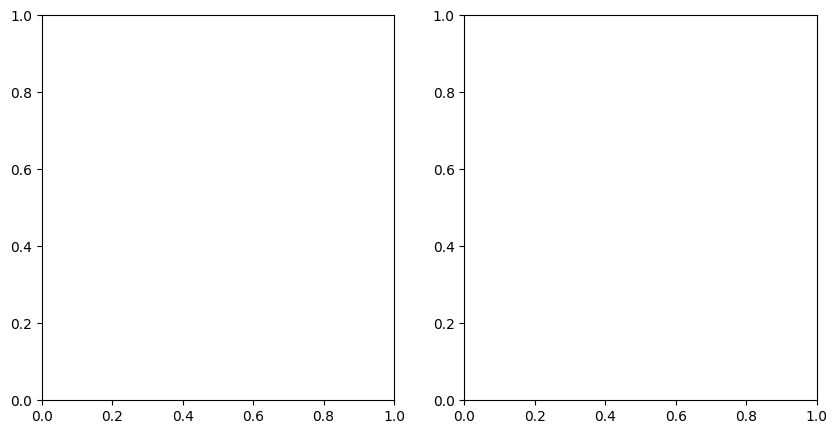

In [31]:
animate_dicom_vs_numpy("D:\\Rafa\\A1Uni\\2semestre\\Estágio\\data\\ILD_DB_txtROIs\\7")